In [1]:
import cv2
import time
import numpy as np
import torch
import random
from torch import Tensor
import json
import os
from os import listdir
from os.path import isfile, join
from torch.nn import BCEWithLogitsLoss
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as xfms
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
torch.manual_seed(12)
torch.backends.cudnn.deterministic = True

In [4]:
torch.cuda.is_available()

True

## Create Dataset

In [5]:
class CCAgT_Dataset(Dataset):
    def __init__(self, img_dict, transform=None):
        self.img_dir = os.path.join(img_dict, 'images_crop')
        self.mask_dir = os.path.join(img_dict, 'masks_crop')
        self.categories = [f"category_{i}" for i in range(1, 8)]
        self.transform = transform

        self.image_paths = []
        self.mask_paths = []

        for category in self.categories:
            img_path = os.path.join(self.img_dir, category)
            mask_path = os.path.join(self.mask_dir, category)
            sorted_img = sorted([os.path.join(img_path, f) for f in listdir(img_path) if isfile(join(img_path, f))])
            sorted_mask = sorted([os.path.join(mask_path, f) for f in listdir(mask_path) if isfile(join(mask_path, f))])
            self.image_paths.extend(sorted_img)
            self.mask_paths.extend(sorted_mask)

        for i, m in zip(self.image_paths, self.mask_paths):
            assert i.split('/')[-1].split('.')[0] == m.split('/')[-1].split('.')[0], "Image and mask names should be same"

            assert i.split('/')[-1].split('.')[1] == 'jpg', "Image should be in jpg format"
            assert m.split('/')[-1].split('.')[1] == 'png', "Mask should be in png format"

            assert os.path.exists(i), f"Image path {i} does not exist"
            assert os.path.exists(m), f"Mask path {m} does not exist"

        assert len(self.image_paths) == len(self.mask_paths), "Number of images and masks should be equal"

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(img_path)
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask) * 255

        return image, mask

In [6]:
img_size = [512, 512]
LR = 1e-4
BATCH = 12
EPOCHS = 30
PATH_DICT = './size_512'

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()
])
test_transform = transforms.ToTensor()

dataset = CCAgT_Dataset(PATH_DICT, transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

trainset, valset, testset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

trainloader = DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=10)
valloader = DataLoader(valset, batch_size=BATCH, shuffle=False, num_workers=10)
testloader = DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=10)

In [7]:
def contours_generate(input_img,fusion_img):
    input_img = np.float32(input_img)
    img_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    img_gray *= 255
    colors = [(255,50,0),(131,60,11),(0,255,0),(0,0,255),(255,0,255),(255,0,0),(0,0,128)]
    for threshhold in range(1,8):
        ret, thresh = cv2.threshold(np.uint8(img_gray),(threshhold*36-1), 255, cv2.THRESH_BINARY)
        contours, hierarchy = cv2.findContours(thresh, 3, 2)
        if contours:
            if threshhold == 1:
                hull = cv2.drawContours(fusion_img, contours, -1, colors[threshhold-2], 6)
            else:
                hull = cv2.drawContours(hull, contours, -1, colors[threshhold-2], 6)
        else :
            hull = fusion_img
    return hull

def vs_generate(input_mask, gen_mask, fusion):
    err_space = np.float64(np.logical_xor(input_mask, gen_mask))
    corr_space = np.logical_and(input_mask, gen_mask)
    R,G,B = cv2.split(err_space)
    R[R==0] = 0.18
    G[G==0] = 0.46
    G[G>0.47] = 0
    B[B==0] = 0.71
    B[B>0.72] = 0
    err_space =cv2.merge([R,G,B])
    
    err_space *= np.float64(np.logical_not(corr_space))
    corr_space = np.float64(corr_space)
    corr_space *= fusion
    err_space += corr_space
    return err_space

def compress_channel(input_batch_img, threshold):
    single_img = torch.zeros(1, input_batch_img.size(2), input_batch_img.size(3))
    output_batch_img = torch.zeros(input_batch_img.size(0), 1,
                                   input_batch_img.size(2), input_batch_img.size(3))
    for idx,n in enumerate(input_batch_img):
        for ch,img in enumerate(n):
            single_img[0][ img > threshold ] = ch
        output_batch_img[idx] = single_img
    return output_batch_img

def show_images(input_imgs, input_masks: None, gen_masks= None,
                nrow=5, ncol=1, show: bool = True, save: bool = False, path ="", mode: bool =False):
    # compare and show n*m images from generator in one figure and optionally save it
    if input_imgs.shape[0] < nrow:
        nrow = input_imgs.shape[0]
    figsize = (nrow*3+2,9)
    count = 311
    img_label = ["input\nimages", "input\nmask"]
    inputs = [input_imgs, input_masks]
    offset = -0.1

    if mode == True and gen_masks == None:
        print("Input ERROR! Expected [gen_mask] but got [None].")
        return None
        
    elif mode == True and gen_masks != None:
        figsize = (nrow*3+2,18)
        count = 611
        img_label.append("generated\nmask")
        inputs.append(gen_masks)

    plt.figure(figsize=figsize)
    for imgs, label in zip([imgs for imgs in inputs if input_masks is not None], img_label):
        imgs = imgs[:nrow * ncol]
        imgs = imgs.view(imgs.size(0), imgs.size(1), 512, 512)
        ax = plt.subplot(count)
        ax.set_title(label ,x=offset, y=0.35)
        img = np.transpose(make_grid(imgs, nrow=nrow, padding=2, normalize=True).cpu(), (1, 2, 0))
        img = np.float32(np.array(img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img.shape[1]*2, int(img.shape[0]*1.5)), interpolation=cv2.INTER_AREA)
        plt.axis("off")
        plt.imshow(img)

        if label == "input\nmask":
            input_mask = img
        if label == "generated\nmask":
            gen_mask = img

        if label == "input\nimages":
            origin_img = img/3+0.6
        else :
            count+=1
            ax = plt.subplot(count)
            name = label.split("\n")[0] + "\nfusion"
            ax.set_title(name,x=offset, y=0.35)
            fusion = origin_img.copy()
            contours_generate(img,fusion)
            plt.axis("off")
            plt.imshow(fusion)
        
        if label == "generated\nmask":
            count+=1
            ax = plt.subplot(count)
            name = "ground truth\nvs\ngenerated"
            ax.set_title(name,x=offset, y=0.35)
            fusion = origin_img.copy()
            vs = vs_generate(input_mask, gen_mask, fusion)
            #print(vs,)
            plt.axis("off")
            plt.imshow(vs)
        count+=1
    if save:
        plt.savefig('./show.png')
    if show:
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


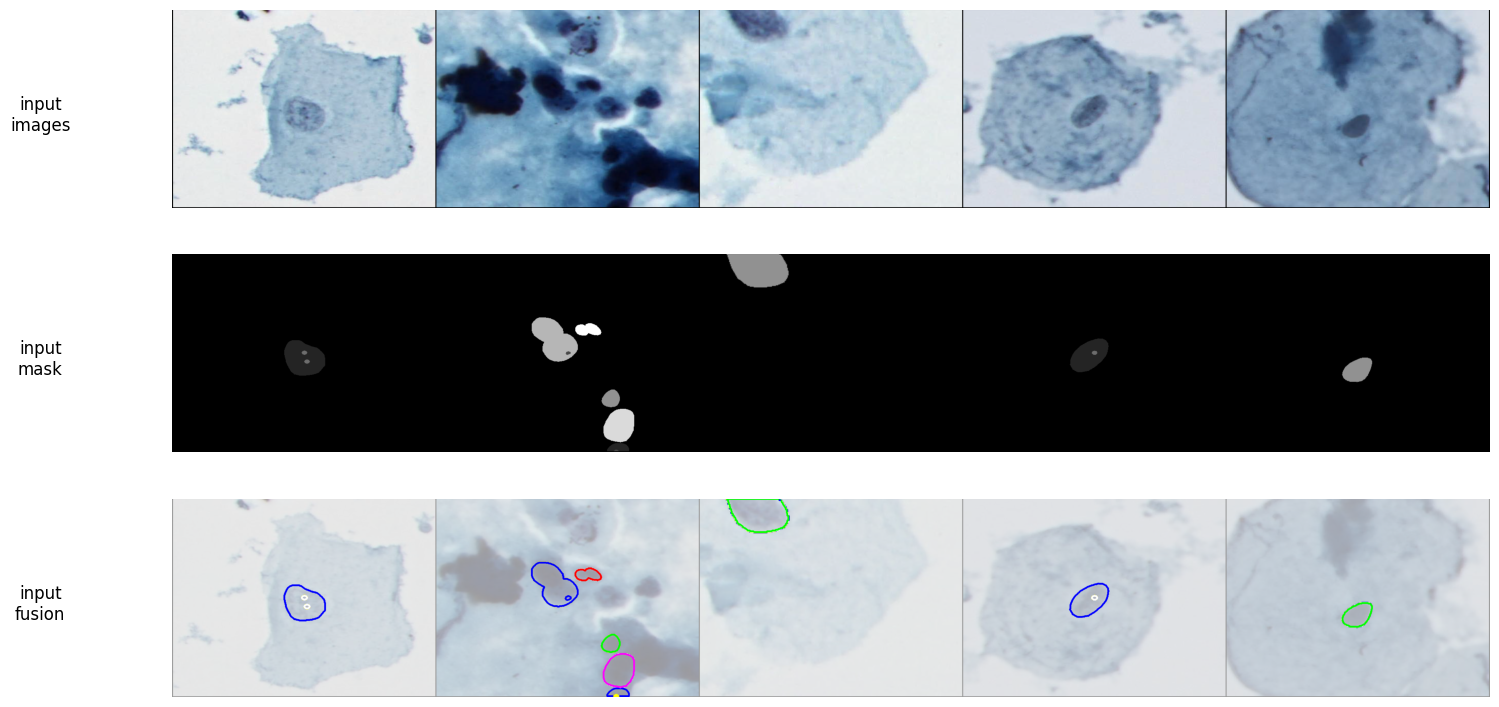

In [8]:
# img, mask = next(iter(trainloader))
img, mask = next(iter(testloader))
assert len(img) == len(mask) == BATCH, "Batch size should be equal"
show_images(img, mask, nrow=5, ncol=1, show=True, save=False, mode=False)

## Training

In [9]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            nn.SiLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            nn.SiLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        
        # Encoder
        self.inc = DoubleConv(n_channels, 32)
        self.down1 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(32, 64)
        )
        self.down2 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(64, 128)
        )
        self.down3 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(128, 256)
        )
        self.down4 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(256, 512)
        )

        # Decoder
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(128, 64)

        self.up4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(64, 32)

        # Output layer
        self.outc = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5)
        x = torch.cat([self.crop(x4, x), x], dim=1)
        x = self.conv1(x)

        x = self.up2(x)
        x = torch.cat([self.crop(x3, x), x], dim=1)
        x = self.conv2(x)

        x = self.up3(x)
        x = torch.cat([self.crop(x2, x), x], dim=1)
        x = self.conv3(x)

        x = self.up4(x)
        x = torch.cat([self.crop(x1, x), x], dim=1)
        x = self.conv4(x)

        return self.outc(x)

    def crop(self, enc, dec):
        diffY = enc.size()[2] - dec.size()[2]
        diffX = enc.size()[3] - dec.size()[3]

        enc = enc[:, :, diffY//2:enc.size()[2]-diffY//2, diffX//2:enc.size()[3]-diffX//2]
        return enc


In [10]:
NUM_CLASSES = 8
unet = UNet(n_channels=3, n_classes=NUM_CLASSES).to(device)
optimizer = optim.Adam(unet.parameters(), lr = LR)
grad_scaler = torch.amp.GradScaler('cuda', enabled=False)
criterion = nn.CrossEntropyLoss() 
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

In [11]:
train_loss = []
val_loss = []
loss_prev = 10
for epoch in (range(EPOCHS)):
    unet.train()  
    epoch_loss = 0
    i_bar = tqdm(trainloader, unit='iter', desc=f'epoch{epoch}')

    # Training loop
    for (imgs, masks) in i_bar:
        masks = masks.long()
        masks = torch.clamp(masks, 0, NUM_CLASSES-1)
        imgs, masks = imgs.to(device), masks.to(device)  # 將數據移動到 GPU 或 CPU
        optimizer.zero_grad()  # 清除梯度
        with torch.amp.autocast('cuda', enabled=False):
            outputs = unet(imgs)
            loss = criterion(outputs, masks.squeeze(1))
        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()
        epoch_loss += loss.item()  # 累加損失
        i_bar.set_postfix(loss=loss.item())  # 更新進度條上的損失

    train_loss.append(epoch_loss / len(trainloader))  # 記錄訓練損失

    # Validation loop
    val_epoch_loss = 0
    with torch.no_grad():
        unet.eval()
        for (imgs, masks) in valloader:
            imgs, masks = imgs.to(device), masks.to(device)  # 將數據移動到 GPU 或 CPU
            outputs = unet(imgs)  # 前向傳播
            masks = masks.long()
            masks = torch.clamp(masks, 0, NUM_CLASSES-1)
            loss = criterion(outputs, masks.squeeze(1))  # 計算損失
            val_epoch_loss += loss.item()  # 累加損失
    
    val_loss.append(val_epoch_loss / len(valloader))  # 記錄驗證損失
    print(f"Epoch {epoch}/{EPOCHS - 1}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}")
    print("----------------------------------------------")


epoch0:  10%|▉         | 120/1224 [00:23<03:39,  5.03iter/s, loss=1.6] 


KeyboardInterrupt: 

In [24]:
import time

TIME = time.strftime("%Y%m%d%H%M%S")

torch.save(unet.state_dict(), f'./unet-{TIME}.pth')

np.save(f'./train_loss_{TIME}.npy', np.array(train_loss))
np.save(f'./val_loss_{TIME}.npy', np.array(val_loss))

In [ ]:
unet.load_state_dict(torch.load(f'./unet-{TIME}.pth'))

/tmp/ipykernel_943469/217139374.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load(f'./unet-{TIME}.pth'))


<All keys matched successfully>

Test Loss: 2.5139


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


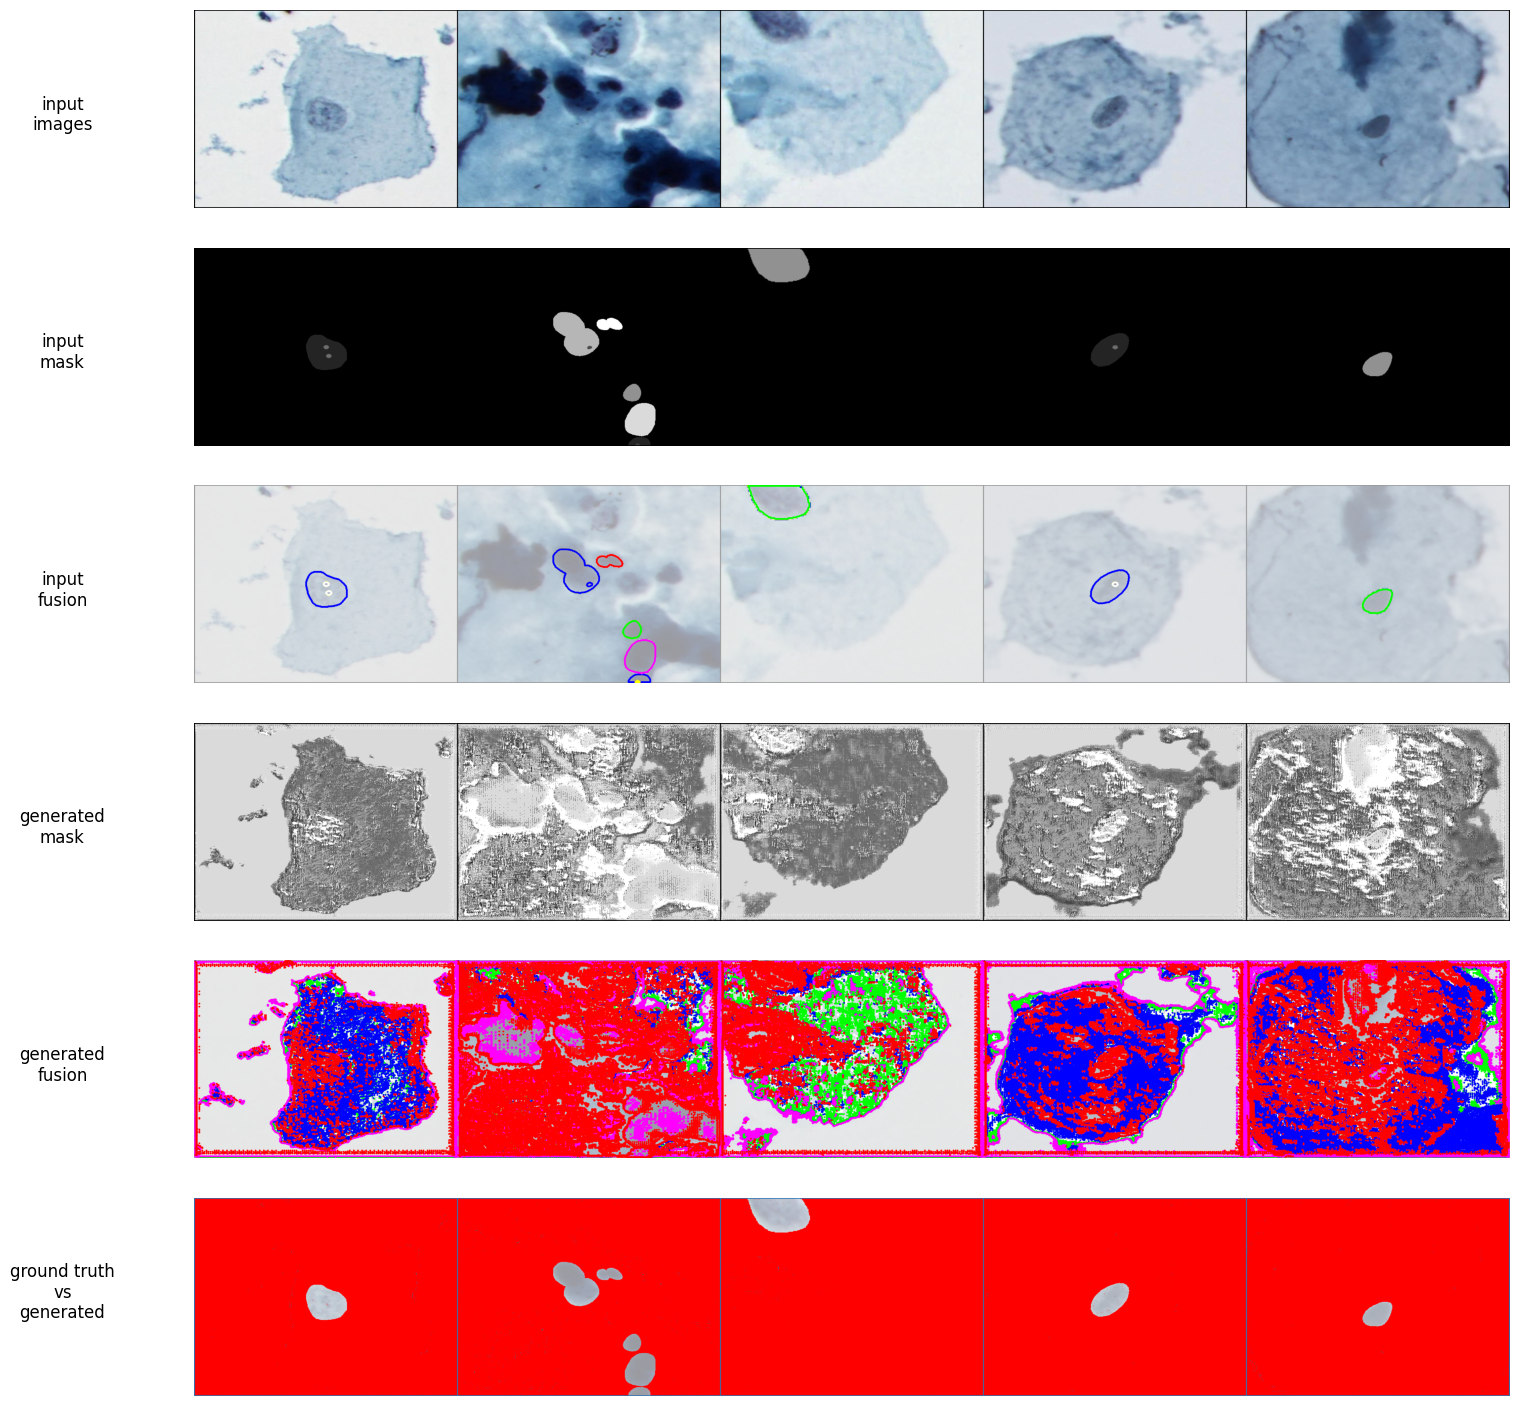

In [ ]:
img, masks = next(iter(testloader))
mmasks = masks.float()
with torch.no_grad():
    unet.eval()
    imgs, masks = img.to(device), masks.to(device)
    masks_pred = unet(imgs)
    masks = masks.long()
    loss = criterion(masks_pred, masks.squeeze(1))
    print(f"Test Loss: {loss.item():.4f}")

pred2show = compress_channel(masks_pred, 0.1)
show_images(imgs, mmasks, gen_masks=pred2show, mode=True)

In [27]:
import torch
import numpy as np
from tqdm import tqdm

# ---------- 定義 mAP_per_batch ----------
def average_precision_at_iou_per_batch(pred_probs, target, num_classes, iou_threshold):
    aps = []
    pred_classes = pred_probs.argmax(dim=1)

    for cls in range(num_classes):
        intersection = ((pred_classes == cls) & (target == cls)).sum().item()
        pred_area = (pred_classes == cls).sum().item()
        target_area = (target == cls).sum().item()

        union = pred_area + target_area - intersection
        if union > 0 and target_area > 0:
            iou_val = intersection / union
            aps.append(1 if iou_val >= iou_threshold else 0)
        else:
            aps.append(0.0)
    return aps

def mAP_per_batch(pred_probs, target, num_classes, iou_thresholds=np.arange(0.5, 1.0, 0.05)):
    mAPs = []
    for iou_threshold in iou_thresholds:
        aps = average_precision_at_iou_per_batch(pred_probs, target, num_classes, iou_threshold)
        mAPs.append(np.mean(aps))
    return np.mean(mAPs)

num_classes = NUM_CLASSES

# 累計用的變數
total_correct = 0
total_pixels = 0

class_true_positive = np.zeros(num_classes, dtype=np.int64)
class_predicted = np.zeros(num_classes, dtype=np.int64)
class_labeled = np.zeros(num_classes, dtype=np.int64)

# IoU / Dice
intersection_sum = np.zeros(num_classes, dtype=np.int64)
union_sum = np.zeros(num_classes, dtype=np.int64)

# Dice 需要的計算
pred_area_sum = np.zeros(num_classes, dtype=np.int64)
target_area_sum = np.zeros(num_classes, dtype=np.int64)
dice_intersection_sum = np.zeros(num_classes, dtype=np.int64)

# mAP 需要的累積
map_list = []

unet.eval()

with torch.no_grad():
    for imgs, masks in tqdm(testloader):
        imgs, masks = imgs.to(device), masks.to(device)
        masks = masks.long()
        masks = torch.clamp(masks, 0, 7).squeeze(1)

        outputs = unet(imgs)
        preds = torch.argmax(outputs, dim=1)  # (batch_size, height, width)

        # Pixel Accuracy (整體像素層級)
        total_correct += (preds == masks).sum().item()
        total_pixels += masks.numel()

        # Class Pixel Accuracy / Mean Pixel Accuracy
        # 定義符合需求
        for i in range(num_classes):
            class_tp = ((preds == i) & (masks == i)).sum().item()  # TP: 預測與標籤一致
            class_pred = (preds == i).sum().item()                 # 預測為該類的總數
            class_label = (masks == i).sum().item()                # 標籤為該類的總數

            class_true_positive[i] += class_tp
            class_predicted[i] += class_pred
            class_labeled[i] += class_label

        # IoU / Dice 累計
        for i in range(num_classes):
            inter = ((preds == i) & (masks == i)).sum().item()
            union = ((preds == i) | (masks == i)).sum().item()

            intersection_sum[i] += inter
            union_sum[i] += union

            dice_intersection_sum[i] += inter
            pred_area_sum[i] += (preds == i).sum().item()
            target_area_sum[i] += (masks == i).sum().item()

        # mAP 累計
        map_list.append(mAP_per_batch(outputs, masks, num_classes))

# ---------- 計算指標 ----------
# Pixel Accuracy
pixel_acc = total_correct / total_pixels
print("Pixel Accuracy:        {:.2f}%".format(pixel_acc * 100))

# Class Pixel Accuracy (預測為 i 裡面有多少是真 i)
cpa = []
for i in range(num_classes):
    if class_predicted[i] > 0:
        cpa_i = class_true_positive[i] / class_predicted[i]
    else:
        cpa_i = 0.0
    cpa.append(cpa_i)
class_acc_str = ", ".join(["{:.2f}%".format(val * 100) for val in cpa])
print("Class Pixel Accuracy:  {}".format(class_acc_str))

# Mean Pixel Accuracy (針對標籤為 i 的像素中，有多少被正確預測)
mean_cpa = np.mean([class_true_positive[i] / class_labeled[i] if class_labeled[i] > 0 else 0.0 for i in range(num_classes)])
print("Mean Pixel Accuracy:   {:.2f}%".format(mean_cpa * 100))

# Dice Coefficient
dice_list = []
for i in range(num_classes):
    denom = pred_area_sum[i] + target_area_sum[i]
    if denom > 0:
        dice_i = 2.0 * dice_intersection_sum[i] / denom
    else:
        dice_i = 0.0
    dice_list.append(dice_i)
dice_str = ", ".join(["{:.3f}".format(val) for val in dice_list])
print("Dice Coefficient:      {}".format(dice_str))

# IoU
ious = []
for i in range(num_classes):
    if union_sum[i] > 0:
        iou_i = intersection_sum[i] / union_sum[i]
    else:
        iou_i = 0.0
    ious.append(iou_i)
ious_str = ", ".join(["{:.3f}".format(val) for val in ious])
print("IoU:                   {}".format(ious_str))
mean_iou = np.mean(ious)
print("Mean IoU:              {:.3f}".format(mean_iou))

# mAP@[.5:.95:.05]
mean_map = np.mean(map_list)
print("mAP@[.5:.95:.05]:      {:.3f}".format(mean_map))

100%|██████████| 525/525 [00:29<00:00, 17.71it/s]

Pixel Accuracy:        6.41%
Class Pixel Accuracy:  92.39%, 12.66%, 0.01%, 0.01%, 0.13%, 1.41%, 0.01%, 0.05%
Mean Pixel Accuracy:   10.45%
Dice Coefficient:      0.095, 0.215, 0.000, 0.000, 0.002, 0.003, 0.000, 0.001
IoU:                   0.050, 0.120, 0.000, 0.000, 0.001, 0.001, 0.000, 0.001
Mean IoU:              0.022
mAP@[.5:.95:.05]:      0.000
